In [92]:
from glob import glob
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.sparse import csr_array
from functools import reduce

from config import *
import sys
sys.path.append("../")


In [142]:
checkpoint = "xgb-adult"
metric = "accuracy"
frac = 0.5

target_files = glob(f"{ckpt_dir}/{checkpoint}-{metric}-noise-{frac:.2f}/target*pkl")
# target_files = glob(f"{ckpt_dir}/{checkpoint}-{metric}/target*pkl")
matches_filename = os.path.join(ckpt_dir, f"matches-{checkpoint}.pkl")

tgt = np.random.choice(target_files)
# tgt = target_files[0]
# tgt = target_files[2]
tgt = '../../models-ckpt/xgb-adult-accuracy-noise-0.50/target-5-12-20-34-77-89.pkl'
with open(tgt, "rb") as f:
    obj = pickle.load(f)
    sg = frozenset(obj["subgroup"])
    accuracies = obj["accuracies"]
    f1 = obj["f1"]
    divs = obj["divs"]
    y_trues = obj["y_trues"]
    y_preds = obj["y_preds"]
    noise_fracs = obj["noise_fracs"]
    altered = obj["altered"]

with open(matches_filename, "rb") as f:
    matches_obj = pickle.load(f)
    df_train = matches_obj["metadata_train"]
    df_tests = matches_obj["metadata_batches"]
    matches = matches_obj["matches_train"]
    matches_ts_list = matches_obj["matches_batches"]

for d in divs:
    d.set_index("subgroup", inplace=True)

ndx = divs[0].index
ndx_target = (ndx == sg).nonzero()[0][0]

In [125]:
[ frozenset(list(map(int,target_files[i].split("target-")[1].split(".pkl")[0].split("-")))) for i in range(len(target_files)) ]

[frozenset({5, 13, 54, 55}),
 frozenset({2, 5, 20, 27, 77, 129}),
 frozenset({0, 12, 26, 40, 129}),
 frozenset({1, 5, 15, 26, 55, 81, 87, 88}),
 frozenset({5, 12, 20, 26, 34, 50, 63, 88}),
 frozenset({15, 26, 34, 57, 70}),
 frozenset({5, 15, 20, 57, 66, 89, 129}),
 frozenset({0, 15, 34, 79}),
 frozenset({5, 12, 15, 34, 50, 57, 77}),
 frozenset({6, 13, 15, 20, 77, 87, 89}),
 frozenset({1, 5, 12, 15, 20, 57, 65, 77, 89}),
 frozenset({13, 34, 59, 80, 89, 129}),
 frozenset({1, 5, 51, 77}),
 frozenset({15, 20, 26, 72, 87, 89}),
 frozenset({5, 12, 15, 26, 34, 50, 55, 78}),
 frozenset({15, 55, 65}),
 frozenset({50, 67, 89}),
 frozenset({40, 59, 87, 129}),
 frozenset({1, 5, 13, 15, 57, 77, 87, 89}),
 frozenset({3, 57, 87, 129}),
 frozenset({2, 15, 20, 28, 77, 89}),
 frozenset({5, 12, 15, 34, 50, 57, 69, 77, 89}),
 frozenset({13, 34, 55, 87, 88}),
 frozenset({2, 5, 14, 20, 34, 48, 87, 129}),
 frozenset({1, 14, 20, 27, 77, 89}),
 frozenset({0, 12, 15, 20, 50, 59, 87}),
 frozenset({1, 6, 15, 20})

In [129]:
matches.fi.set_index("itemsets").loc[[ frozenset(list(map(int,target_files[i].split("target-")[1].split(".pkl")[0].split("-")))) for i in range(len(target_files)) ]].sort_values("support", ascending=False)

,support
itemsets,
"(34, 5, 12, 77, 20, 89)",0.084313
"(34, 5, 12, 77, 15, 50, 57)",0.078785
"(0, 129, 34, 78)",0.071086
"(129, 5, 14, 48, 87, 57)",0.062569
"(0, 12, 15, 50, 20, 87, 59)",0.052127
...,...
"(34, 12, 78, 15, 63)",0.010483
"(0, 129, 40, 12, 26)",0.010442
"(1, 66, 34, 5, 20, 87, 89, 27)",0.010319


In [138]:
"-".join(map(str,sorted([34, 5, 12, 77, 20, 89])))

'5-12-20-34-77-89'

In [144]:
print("Subgroup", sg)
print("Support", matches.matches[:, [ndx_target]].mean())

Subgroup frozenset({34, 5, 12, 77, 20, 89})
Support 0.08431268170836576


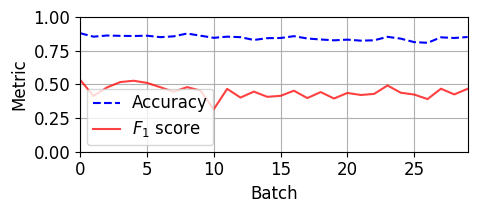

In [145]:
fig, ax = plt.subplots(figsize=(5, 1.75))
# ax.set_title("Overall performance")
ax.plot(accuracies, label="Accuracy", color='b', ls='--')
ax.plot(f1, label="$F_1$ score", color='r', alpha=.75)
ax.set_xlabel("Batch")
ax.set_ylabel("Metric")
ax.legend()
ax.grid()

ax.set_ylim([0., 1.0])
ax.set_xlim([0, 29])

# increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(12)

fig.savefig("f1-acc-overall.pdf", bbox_inches='tight')

In [146]:
for div in divs:
    div["accuracy"] = (div["tp"] + div["tn"]) / (div["tp"] + div["tn"] + div["fp"] + div["fn"])

In [147]:
# implement AND operation as product between boolean vectors 
mm_bool = matches.matches.astype(bool)
# "broadcast" to desired shape (matrix multiplication with vector of 1's)
ndx_vec_bool = (matches.matches[:, [ndx_target]].astype(bool) @ csr_array(np.ones((1, matches.matches.shape[1]))).astype(bool))
overlaps = (mm_bool * ndx_vec_bool).sum(axis=0) # element-wise product as "&", sum along axis=0 to get count of matches
total = matches.matches.sum(axis=0)
overlaps = overlaps / total

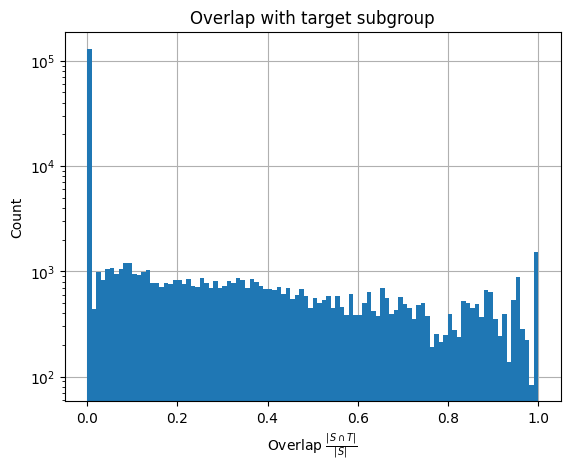

In [148]:
fig, ax = plt.subplots()
ax.set_title("Overlap with target subgroup")
ax.hist(overlaps, bins=100)
ax.set_yscale("log")
ax.set_xlabel("Overlap $\\frac{|S \\cap T|}{|S|}$")
ax.set_ylabel("Count")
ax.grid()
ax.set_axisbelow(True)

In [149]:
scores = np.vstack([ d[metric].values for d in divs ]).T

In [150]:
window = 5
delay = 10
start_noise = window
equal_var = False

1 (Overlap 1.00) {65, 34, 1, 5, 12, 77, 15, 20, 87, 57} ({34, 20, 5, 12, 77})
2 (Overlap 0.76) {65, 129, 5, 26, 12, 77, 15} ({77, 12, 5})


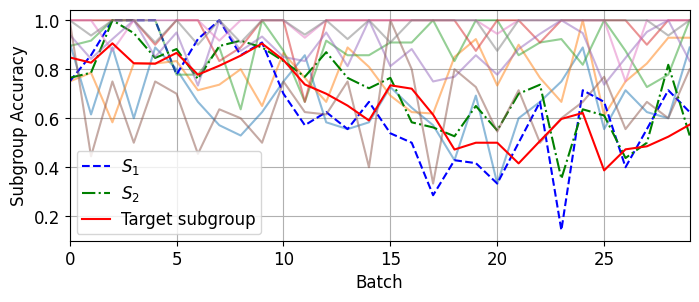

In [161]:
fig, ax = plt.subplots(figsize=(8, 3))
np.random.seed(5)
random_10 = np.random.choice(scores.shape[0], 10, replace=False)


c = 1
colors = "bgky"
style = ['--', '-.', ':']
for i in random_10:
    if overlaps[i] > 0.5:
    # if overlaps[i] > 0.193:
        print(f"{c} (Overlap {overlaps[i]:.2f}) {set(ndx[i])} ({ set(ndx[i] & sg) })")
        ax.plot(scores[i], label=f"$S_{c}$", color=colors[c-1], ls=style[c-1])
        c += 1
    else:
        ax.plot(scores[i], alpha=.5)#, label=f"subgroup {i}", alpha=.5)

ax.plot(scores[ndx_target], color='r', label="Target subgroup")
# ax.axvspan(0, 2, alpha=0.2, color='green')
# ax.axvspan(29 - 2, 29, alpha=.2, color='red')
# ax.legend()
ax.set_xlabel("Batch")
ax.set_ylabel(f"Subgroup Accuracy")
ax.grid()
ax.set_axisbelow(True)
ax.legend()
# increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(12)
ax.set_xlim([0, 29])
fig.savefig("drift-example.pdf", bbox_inches="tight")

In [152]:
E1 = reduce(lambda a,b : a + b, [ div["accuracy"] for div in divs[:start_noise] ]) / start_noise
E2 = reduce(lambda a,b : a + b, [ div["accuracy"] for div in divs[-window:] ]) / window

delta = E2 - E1
Var1 = reduce(lambda a,b : a + b, [ (div["accuracy"] - E1) ** 2 for div in divs[:start_noise] ]) / (start_noise - 1)
Var2 = reduce(lambda a,b : a + b, [ (div["accuracy"] - E2) ** 2 for div in divs[-window:] ]) / (window - 1)

t_stat = abs(delta) / np.sqrt(Var1 / start_noise + Var2 / window + 1e-12)

variance = Var1 / start_noise + Var2 / window

In [153]:
def get_altered_in_window(matches_ts_list, altered_frac, start_ndx, end_ndx):
    sizes = np.array([ m.matches.shape[0] for m in matches_ts_list ])
    return (np.vstack(altered_frac[start_ndx:end_ndx]) * sizes[start_ndx:end_ndx].reshape(-1,1)).sum(axis=0) / sizes[start_ndx:end_ndx].sum()


In [154]:
len(altered)

30

In [155]:
altered_per_sg = np.vstack([ matches_ts_list[i].matches[altered[i]].sum(axis=0) for i in range(len(matches_ts_list)) ])
count_per_sg =   np.vstack([ matches_ts_list[i].matches.sum(axis=0) for i in range(len(matches_ts_list)) ])
count_per_sg[count_per_sg == 0] = 1 # avoid division by 0 (fraction will still be 0)
# altered_frac = [ matches_ts_list[i].matches[altered[i]].sum(axis=0) / matches_ts_list[i].matches.sum(axis=0) for i in range(len(matches_ts_list)) ]
altered_frac = altered_per_sg / count_per_sg

In [156]:
# altered1 = get_altered_in_window(matches_ts_list, altered_frac, 0, start_noise) # not used
altered2 = get_altered_in_window(matches_ts_list, altered_frac, -window, None) # how many were altered in the last window? (fraction, for each subgroup)
altered2[np.isnan(altered2)] = 0

In [157]:
from sklearn.metrics import ndcg_score


In [158]:
delta_values = delta.values
delta_values[np.isnan(delta_values)] = 0

tstat_values = t_stat.values
tstat_values[np.isnan(tstat_values)] = 0

In [159]:
ndcg_score(altered2.reshape(1,-1), -delta_values.reshape(1,-1)), ndcg_score(altered2.reshape(1,-1), tstat_values.reshape(1,-1))

(0.9853073071366816, 0.9645645797359473)

Correlation -0.8333578473130641
Correlation 0.7254114625780057


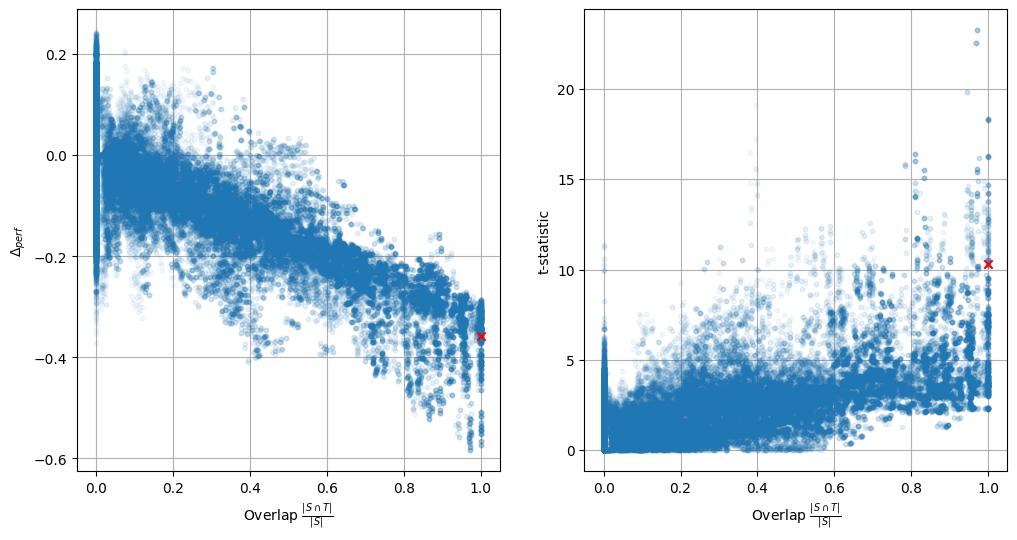

In [160]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(overlaps, delta, alpha=.05, s=10)
ax[0].scatter([overlaps[ndx_target]], [delta[ndx_target]], marker='x', c='r')
ax[0].set_xlabel(r"Overlap $\frac{|S \cap T|}{|S|}$")
ax[0].set_ylabel(r"$\Delta_{perf}$")
ax[0].grid()
ax[0].set_axisbelow(True)
print("Correlation", np.corrcoef(overlaps, delta)[0,1])

ax[1].scatter(overlaps, t_stat, alpha=.05, s=10)
ax[1].scatter([overlaps[ndx_target]], [t_stat[ndx_target]], marker='x', c='r')
ax[1].set_xlabel(r"Overlap $\frac{|S \cap T|}{|S|}$")
ax[1].set_ylabel(r"t-statistic")
ax[1].grid()
ax[1].set_axisbelow(True)
print("Correlation", np.corrcoef(overlaps, t_stat)[0,1])

In [111]:
tgt

'../../models-ckpt/xgb-adult-accuracy-noise-0.50/target-5-13-15-26-34-54-74.pkl'

In [114]:
# implement AND operation as product between boolean vectors 
mm_bool = matches.matches.astype(bool)

skip = 0
all_experiments = {}

# for window in [5]:
for window in range(2, 11):

    if window not in all_experiments:
        all_experiments[window] = []

        print("Window", window)

        start_noise = window
        np.random.shuffle(target_files)
        n_files = 100

        for approach in ["single-batch", "multi-batch"]:
            ndcg_delta = []
            ndcg_tstat = []

            with tqdm(target_files[:n_files]) as pbar:
                for tgt_file in pbar:
                    with open(tgt_file, "rb") as f:
                        obj = pickle.load(f)
                        sg = frozenset(obj["subgroup"])
                        accuracies = obj["accuracies"]
                        f1 = obj["f1"]
                        divs = obj["divs"]
                        y_trues = obj["y_trues"]
                        y_preds = obj["y_preds"]
                        altered = obj["altered"]

                    for d in divs:
                        d.set_index("subgroup", inplace=True)
                        d["accuracy"] = (d["tp"] + d["tn"]) / (d["tp"] + d["tn"] + d["fp"] + d["fn"])

                    ndx = divs[0].index
                    ndx_target = (ndx == sg).nonzero()[0][0]

                    # "broadcast" to desired shape (matrix multiplication with vector of 1's)
                    # ndx_vec_bool = (matches.matches[:, [ndx_target]].astype(bool) @ csr_array(np.ones((1, matches.matches.shape[1]))).astype(bool))
                    # overlaps = (mm_bool * ndx_vec_bool).sum(axis=0) # element-wise product as "&", sum along axis=0 to get count of matches
                    # total = matches.matches.sum(axis=0)
                    # overlaps = overlaps / total

                    if approach == "single-batch":
                        a1 = reduce(lambda a,b : a + b, [ div["tp"] + div["tn"] for div in divs[skip:skip+window] ])
                        b1 = reduce(lambda a,b : a + b, [ div["fp"] + div["fn"] for div in divs[skip::skip+window] ])

                        E1 = a1 / (a1 + b1)
                        Var1 = (a1 * b1) / ((a1 + b1) ** 2 * (a1 + b1 + 1))

                        a2 = reduce(lambda a,b : a + b, [ div["tp"] + div["tn"] for div in divs[-window:] ])
                        b2 = reduce(lambda a,b : a + b, [ div["fp"] + div["fn"] for div in divs[-window:] ])

                        E2 = a2 / (a2 + b2)
                        Var2 = (a2 * b2) / ((a2 + b2) ** 2 * (a2 + b2 + 1))

                        delta = E2 - E1
                        variance = Var1 + Var2

                        t_stat = abs(delta) / np.sqrt(variance + 1e-12) # eps to avoid division by 0
                    elif approach == "multi-batch":
                        E1 = reduce(lambda a,b : a + b, [ div["accuracy"] for div in divs[skip:skip+window] ]) / window
                        E2 = reduce(lambda a,b : a + b, [ div["accuracy"] for div in divs[-window:] ]) / window

                        delta = E2 - E1
                        Var1 = reduce(lambda a,b : a + b, [ (div["accuracy"] - E1) ** 2 for div in divs[skip:skip+window] ]) / (window - 1)
                        Var2 = reduce(lambda a,b : a + b, [ (div["accuracy"] - E2) ** 2 for div in divs[-window:] ]) / (window - 1)

                        t_stat = abs(delta) / np.sqrt(Var1 / start_noise + Var2 / window + 1e-12)

                        variance = Var1 / start_noise + Var2 / window
                    
                    # disable warnin
                    altered_per_sg = np.vstack([ matches_ts_list[i].matches[altered[i]].sum(axis=0) for i in range(len(matches_ts_list)) ])
                    count_per_sg =   np.vstack([ matches_ts_list[i].matches.sum(axis=0) for i in range(len(matches_ts_list)) ])
                    count_per_sg[count_per_sg == 0] = 1 # avoid division by 0 (fraction will still be 0)
                    altered_frac = altered_per_sg / count_per_sg

                    altered2 = get_altered_in_window(matches_ts_list, altered_frac, -window, None) # how many were altered in the last window? (fraction, for each subgroup)
                    altered2[np.isnan(altered2)] = 0

                    delta_values = delta.values
                    delta_values[np.isnan(delta_values)] = 0

                    tstat_values = t_stat.values
                    tstat_values[np.isnan(tstat_values)] = 0

                    ndcg_delta.append(ndcg_score(altered2.reshape(1,-1), -delta_values.reshape(1,-1)))
                    ndcg_tstat.append(ndcg_score(altered2.reshape(1,-1), tstat_values.reshape(1,-1)))
                    
                    pbar.set_postfix({"NDCG delta_perf": np.mean(ndcg_delta), "NDCG t_stat": np.mean(ndcg_tstat)})

Window 2


100%|██████████| 100/100 [02:53<00:00,  1.74s/it, NDCG delta_perf=0.806, NDCG t_stat=0.771]


Window 3


100%|██████████| 100/100 [02:57<00:00,  1.77s/it, NDCG delta_perf=0.848, NDCG t_stat=0.799]


Window 4


100%|██████████| 100/100 [03:00<00:00,  1.80s/it, NDCG delta_perf=0.856, NDCG t_stat=0.816]


Window 5


100%|██████████| 100/100 [03:04<00:00,  1.84s/it, NDCG delta_perf=0.879, NDCG t_stat=0.841]


Window 6


100%|██████████| 100/100 [03:11<00:00,  1.91s/it, NDCG delta_perf=0.89, NDCG t_stat=0.855]


Window 7


100%|██████████| 100/100 [03:16<00:00,  1.96s/it, NDCG delta_perf=0.895, NDCG t_stat=0.866]


Window 8


100%|██████████| 100/100 [03:20<00:00,  2.01s/it, NDCG delta_perf=0.904, NDCG t_stat=0.874]


Window 9


100%|██████████| 100/100 [03:28<00:00,  2.09s/it, NDCG delta_perf=0.907, NDCG t_stat=0.88]


Window 10


100%|██████████| 100/100 [03:35<00:00,  2.16s/it, NDCG delta_perf=0.913, NDCG t_stat=0.886]


1 sigma =>  56
2 sigma =>  168
3 sigma =>  364


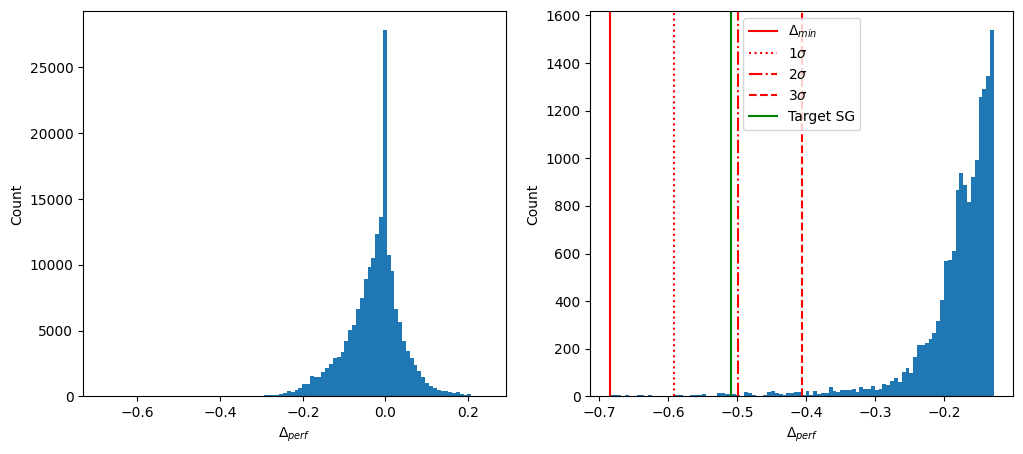

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(delta, bins=100)
ax[0].set_xlabel(r"$\Delta_{perf}$")
ax[0].set_ylabel("Count")


ax[1].axvline(delta.min(), c='r', label=r'$\Delta_{min}$')
ax[1].axvline(delta.min() + 1 * variance[delta.argmin()]**.5, c='r', linestyle=':', label=r'$1 \sigma$')
ax[1].axvline(delta.min() + 2 * variance[delta.argmin()]**.5, c='r', linestyle='-.', label=r'$2 \sigma$')
ax[1].axvline(delta.min() + 3 * variance[delta.argmin()]**.5, c='r', linestyle='--', label=r'$3 \sigma$')
ax[1].axvline(delta[sg], c='g', linestyle='-', label=r'Target SG')
ax[1].hist(delta[delta < delta.min() + 6 * variance[delta.argmin()]**.5], bins=100)
ax[1].set_xlabel(r"$\Delta_{perf}$")
ax[1].set_ylabel("Count")
ax[1].legend()

print("1 sigma => ", (delta < (delta.min() + 1 * variance[delta.argmin()]**.5)).sum())
print("2 sigma => ", (delta < (delta.min() + 2 * variance[delta.argmin()]**.5)).sum())
print("3 sigma => ", (delta < (delta.min() + 3 * variance[delta.argmin()]**.5)).sum())

In [19]:
mask_3sigma = (delta < (delta.min() + 3 * variance[delta.argmin()]**.5))
candidates = set(divs[0].loc[mask_3sigma].index)


kept = []

print("Candidates:", len(candidates))
print("Target in candidates:", sg in candidates)

for el in candidates:
    shortest = True
    for oth in candidates:
        if oth == el:
            continue
        
        if oth < el:
            shortest = False
            break
    if shortest:
        kept.append(el)
len(candidates), len(kept), sg in candidates, sg in kept

Candidates: 93418
Target in candidates: True


(93418, 74, True, False)

In [20]:
# mask_3sigma = (delta < (delta.min() + 3 * variance[delta.argmin()]**.5))
topn = 50

kept = []

candidates = set(delta.sort_values()[:topn].index)

print("Candidates:", len(candidates))
print("Target in candidates:", sg in candidates)

for el in candidates:
    shortest = True
    for oth in candidates:
        if oth == el:
            continue
        
        if oth < el:
            shortest = False
            break
    if shortest:
        kept.append(el)
len(candidates), len(kept), sg in candidates, sg in kept

Candidates: 50
Target in candidates: True


(50, 15, True, False)

In [21]:
# initial window
from functools import reduce

a1 = reduce(lambda a,b : a + b, [ div["tp"] + div["tn"] for div in divs[:start_noise] ])
b1 = reduce(lambda a,b : a + b, [ div["fp"] + div["fn"] for div in divs[:start_noise] ])

E1 = a1 / (a1 + b1)
Var1 = (a1 * b1) / ((a1 + b1) ** 2 * (a1 + b1 + 1))

a2 = reduce(lambda a,b : a + b, [ div["tp"] + div["tn"] for div in divs[start_noise+delay:start_noise+delay+window] ])
b2 = reduce(lambda a,b : a + b, [ div["fp"] + div["fn"] for div in divs[start_noise+delay:start_noise+delay+window] ])

E2 = a2 / (a2 + b2)
Var2 = (a2 * b2) / ((a2 + b2) ** 2 * (a2 + b2 + 1))

In [22]:
delta = E2 - E1
variance = Var1 + Var2

t_stat = abs(delta) / np.sqrt(variance + 1e-12)

Correlation -0.18675700013453397
Correlation 0.17954243403359854


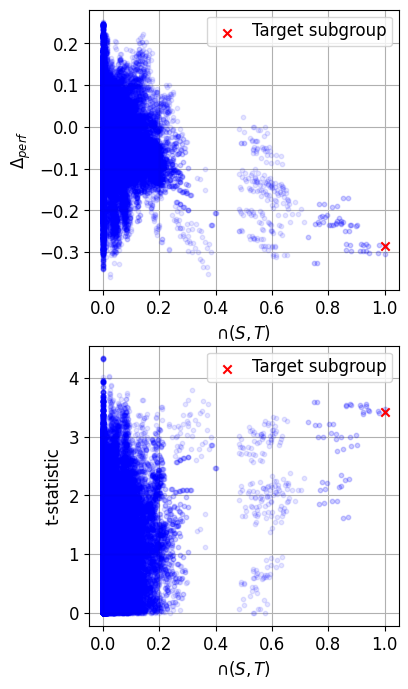

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(4, 8))

ax[0].scatter(overlaps, delta, alpha=.1, s=10, c='b')
ax[0].scatter([overlaps[ndx_target]], [delta[ndx_target]], marker='x', c='r', label="Target subgroup")
# ax[0].set_xlabel(r"Overlap $\frac{|S \cap T|}{|S|}$")
ax[0].set_xlabel(r"$\cap(S, T)$")
ax[0].set_ylabel(r"$\Delta_{perf}$")
ax[0].grid()
ax[0].set_axisbelow(True)
ax[0].legend()
print("Correlation", np.corrcoef(overlaps, delta)[0,1])

ax[1].scatter(overlaps, t_stat, alpha=.1, s=10, c='b')
ax[1].scatter([overlaps[ndx_target]], [t_stat[ndx_target]], marker='x', c='r', label="Target subgroup")
# ax[1].set_xlabel(r"Overlap $\frac{|S \cap T|}{|S|}$")
ax[1].set_xlabel(r"$\cap(S, T)$")
ax[1].set_ylabel(r"t-statistic")
ax[1].grid()
ax[1].legend()
ax[1].set_axisbelow(True)

# increase font sizes
for i in range(2):
    for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] +
                ax[i].get_xticklabels() + ax[i].get_yticklabels() + ax[i].legend().get_texts()):
        item.set_fontsize(12)

print("Correlation", np.corrcoef(overlaps, t_stat)[0,1])

fig.savefig("correlation.pdf", bbox_inches="tight")

1 sigma =>  574
2 sigma =>  5176
3 sigma =>  31131


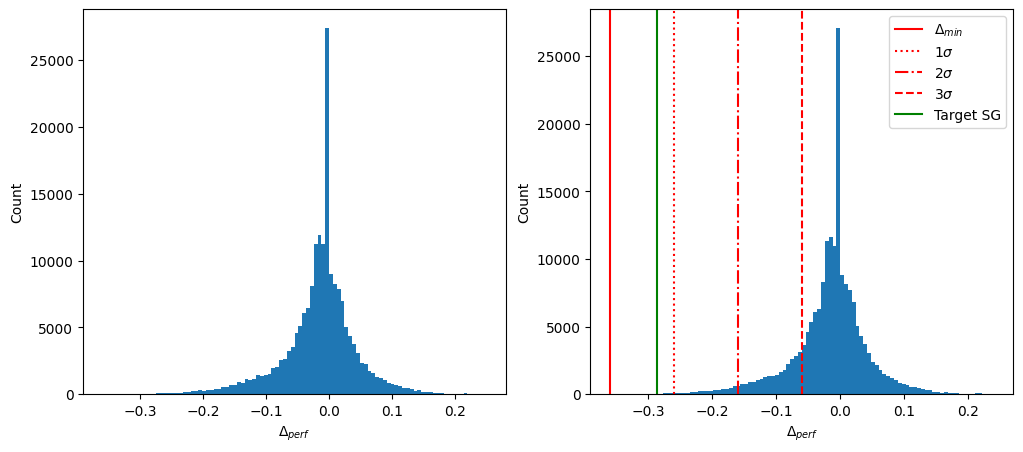

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(delta, bins=100)
ax[0].set_xlabel(r"$\Delta_{perf}$")
ax[0].set_ylabel("Count")


ax[1].axvline(delta.min(), c='r', label=r'$\Delta_{min}$')
ax[1].axvline(delta.min() + 1 * variance[delta.argmin()]**.5, c='r', linestyle=':', label=r'$1 \sigma$')
ax[1].axvline(delta.min() + 2 * variance[delta.argmin()]**.5, c='r', linestyle='-.', label=r'$2 \sigma$')
ax[1].axvline(delta.min() + 3 * variance[delta.argmin()]**.5, c='r', linestyle='--', label=r'$3 \sigma$')
ax[1].axvline(delta[sg], c='g', linestyle='-', label=r'Target SG')
ax[1].hist(delta[delta < delta.min() + 6 * variance[delta.argmin()]**.5], bins=100)
ax[1].set_xlabel(r"$\Delta_{perf}$")
ax[1].set_ylabel("Count")
ax[1].legend()

print("1 sigma => ", (delta < (delta.min() + 1 * variance[delta.argmin()]**.5)).sum())
print("2 sigma => ", (delta < (delta.min() + 2 * variance[delta.argmin()]**.5)).sum())
print("3 sigma => ", (delta < (delta.min() + 3 * variance[delta.argmin()]**.5)).sum())

In [36]:
mask_3sigma = (delta < (delta.min() + 3 * variance[delta.argmin()]**.5))

kept = []

candidates = set(divs[0].loc[mask_3sigma].index)

print("Candidates:", len(candidates))
print("Target in candidates:", sg in candidates)

for el in candidates:
    shortest = True
    for oth in candidates:
        if oth == el:
            continue
        
        if oth < el:
            shortest = False
            break
    if shortest:
        kept.append(el)
len(candidates), len(kept), sg in candidates, sg in kept

Candidates: 52
Target in candidates: True


(52, 5, True, False)

# Compute metrics

In [25]:
from tqdm import tqdm

In [27]:
# implement AND operation as product between boolean vectors 
mm_bool = matches.matches.astype(bool)

n_runs = 2

approach = "multi-batch" # or "single-batch"

skip = 5
all_experiments = {}

# for window in [5]:
for window in range(2, 11):

    if window not in all_experiments:
        all_experiments[window] = []
    
    for run in range(n_runs):

        print("Window", window, "run #", run)

        start_noise = window

        sigmas = 3

        outcome = []
        outcome_prune = []
        sigma_dists = []
        ranks = [] # for mrr
        size = []
        tstats = []
        candidates_num = []
        deltas = []
        corr_overlap_delta = []
        corr_overlap_tstat = []

        np.random.shuffle(target_files)
        n_files = 100

        for approach in ["single-batch", "multi-batch"]:
            print(approach)
            with tqdm(target_files[:n_files]) as pbar:
                for tgt_file in pbar:
                    with open(tgt_file, "rb") as f:
                        obj = pickle.load(f)
                        sg = frozenset(obj["subgroup"])
                        accuracies = obj["accuracies"]
                        f1 = obj["f1"]
                        divs = obj["divs"]
                        y_trues = obj["y_trues"]
                        y_preds = obj["y_preds"]
                        # blurs = obj["blurs"]

                    for d in divs:
                        d.set_index("subgroup", inplace=True)
                        d["accuracy"] = (d["tp"] + d["tn"]) / (d["tp"] + d["tn"] + d["fp"] + d["fn"])

                    ndx = divs[0].index
                    ndx_target = (ndx == sg).nonzero()[0][0]
                    size.append(matches.matches[:, [ndx_target]].mean())

                    # "broadcast" to desired shape (matrix multiplication with vector of 1's)
                    ndx_vec_bool = (matches.matches[:, [ndx_target]].astype(bool) @ csr_array(np.ones((1, matches.matches.shape[1]))).astype(bool))
                    overlaps = (mm_bool * ndx_vec_bool).sum(axis=0) # element-wise product as "&", sum along axis=0 to get count of matches
                    total = matches.matches.sum(axis=0)
                    overlaps = overlaps / total

                    if approach == "single-batch":
                        a1 = reduce(lambda a,b : a + b, [ div["tp"] + div["tn"] for div in divs[skip:skip+window] ])
                        b1 = reduce(lambda a,b : a + b, [ div["fp"] + div["fn"] for div in divs[skip::skip+window] ])

                        E1 = a1 / (a1 + b1)
                        Var1 = (a1 * b1) / ((a1 + b1) ** 2 * (a1 + b1 + 1))

                        a2 = reduce(lambda a,b : a + b, [ div["tp"] + div["tn"] for div in divs[-window:] ])
                        b2 = reduce(lambda a,b : a + b, [ div["fp"] + div["fn"] for div in divs[-window:] ])

                        E2 = a2 / (a2 + b2)
                        Var2 = (a2 * b2) / ((a2 + b2) ** 2 * (a2 + b2 + 1))

                        delta = E2 - E1
                        variance = Var1 + Var2

                        t_stat = abs(delta) / np.sqrt(variance + 1e-12) # eps to avoid division by 0
                    elif approach == "multi-batch":
                        E1 = reduce(lambda a,b : a + b, [ div["accuracy"] for div in divs[skip:skip+window] ]) / window
                        E2 = reduce(lambda a,b : a + b, [ div["accuracy"] for div in divs[-window:] ]) / window

                        delta = E2 - E1
                        Var1 = reduce(lambda a,b : a + b, [ (div["accuracy"] - E1) ** 2 for div in divs[skip:skip+window] ]) / (window - 1)
                        Var2 = reduce(lambda a,b : a + b, [ (div["accuracy"] - E2) ** 2 for div in divs[-window:] ]) / (window - 1)

                        t_stat = abs(delta) / np.sqrt(Var1 / start_noise + Var2 / window + 1e-12)

                        variance = Var1 / start_noise + Var2 / window

                    mask_3sigma = (delta < (delta.min() + sigmas * variance[delta.argmin()]**.5))

                    kept = []

                    candidates = set(divs[0].loc[mask_3sigma].index)
                    candidates_num.append(len(candidates))
                    tstats.append(t_stat[sg])
                    deltas.append(delta[sg])

                    outcome.append(sg in candidates)
                    sigma_dists.append((delta[sg] - delta[delta.argmin()]) / (variance[delta.argmin()]) ** 0.5)
                    ranks.append(1/delta.rank(method="dense")[sg])

                    corr_overlap_delta.append(np.corrcoef(overlaps, delta)[0,1])
                    corr_overlap_tstat.append(np.corrcoef(overlaps, t_stat)[0,1])

                    for el in candidates:
                        shortest = True
                        for oth in candidates:
                            if oth == el:
                                continue
                            
                            if oth < el:
                                shortest = False
                                break
                        if shortest:
                            kept.append(el)
                    
                    outcome_prune.append(sg in kept)

                    pbar.set_postfix({"outcome": np.mean(outcome), "outcome_prune": np.mean(outcome_prune), "sigma_dist": np.mean(sigma_dists), "mrr": np.mean(ranks), "tstat": np.mean(tstats), "deltas": np.mean(deltas), "corr_overlap_delta": np.mean(corr_overlap_delta), "corr_overlap_tstat": np.mean(corr_overlap_tstat)})
            
            # outcome = np.array(outcome)
            # outcome_prune = np.array(outcome_prune)
            # sigma_dists = np.array(sigma_dists)
            # ranks = np.array(ranks)
            # size = np.array(size)
            # tstats = np.array(tstats)
            # candidates_num = np.array(candidates_num)
            # deltas = np.array(deltas)
            # corr_overlap_delta = np.array(corr_overlap_delta)
            # corr_overlap_tstat = np.array(corr_overlap_tstat)

            # all_experiments[window].append({
            #     "outcome": outcome,
            #     "outcome_prune": outcome_prune,
            #     "sigma_dists": sigma_dists,
            #     "ranks": ranks,
            #     "size": size,
            #     "tstats": tstats,
            #     "candidates_num": candidates_num,
            #     "deltas": deltas,
            #     "corr_overlap_delta": corr_overlap_delta,
            #     "corr_overlap_tstat": corr_overlap_tstat
            # })


Window 2 run # 0
single-batch


  6%|▌         | 6/100 [07:22<1:55:38, 73.81s/it, outcome=0.667, outcome_prune=0, sigma_dist=2.73, mrr=0.00341, tstat=1.5, deltas=0.0319, corr_overlap_delta=-.0688, corr_overlap_tstat=-.0104]


KeyboardInterrupt: 

In [57]:
np.mean(corr_overlap_delta), np.mean(corr_overlap_tstat)

(-0.7468600553765254, 0.6745344522054658)

In [27]:
np.isnan(corr_overlap_tstat).nonzero()

(array([77]),)

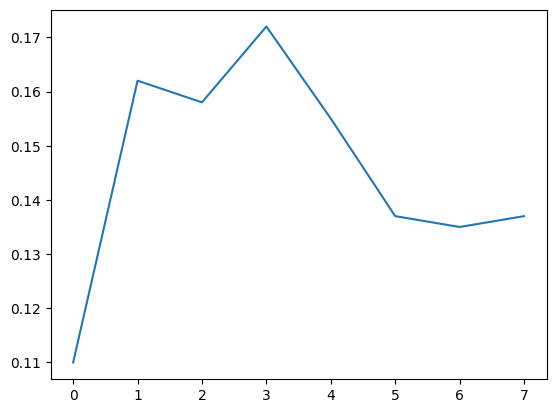

In [173]:
mrr = [ 0.11, 0.162, 0.158, 0.172, 0.155, 0.137, 0.135, 0.137]
plt.plot(mrr)

(array([ 5.,  2.,  3.,  8., 10.,  4.,  6.,  6.,  7.,  6., 16.,  6.,  8.,
         6.,  6.,  8., 13., 12., 11., 10.,  4.,  5.,  6.,  7.,  6.,  8.,
         4.,  4.,  2.,  5.,  2.,  4.,  3.,  1.,  1.,  3.,  2.,  3.,  1.,
         1.,  4.,  4.,  5.,  4.,  2.,  0.,  1.,  3.,  0.,  2.]),
 array([-8.82829050e-01, -8.64063071e-01, -8.45297092e-01, -8.26531113e-01,
        -8.07765134e-01, -7.88999155e-01, -7.70233177e-01, -7.51467198e-01,
        -7.32701219e-01, -7.13935240e-01, -6.95169261e-01, -6.76403282e-01,
        -6.57637303e-01, -6.38871324e-01, -6.20105346e-01, -6.01339367e-01,
        -5.82573388e-01, -5.63807409e-01, -5.45041430e-01, -5.26275451e-01,
        -5.07509472e-01, -4.88743493e-01, -4.69977514e-01, -4.51211536e-01,
        -4.32445557e-01, -4.13679578e-01, -3.94913599e-01, -3.76147620e-01,
        -3.57381641e-01, -3.38615662e-01, -3.19849683e-01, -3.01083704e-01,
        -2.82317726e-01, -2.63551747e-01, -2.44785768e-01, -2.26019789e-01,
        -2.07253810e-01, -1.8848

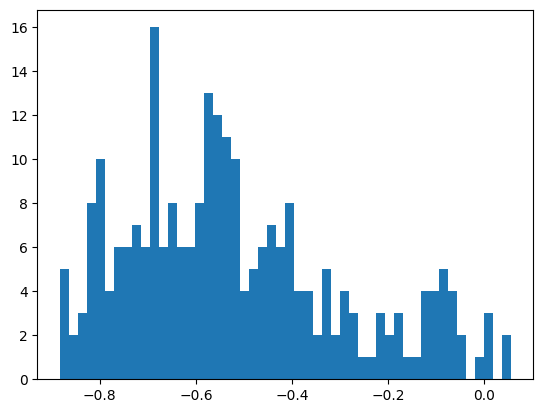

In [161]:
plt.hist(deltas, bins=50)

(array([0.02 , 0.072, 0.092, 0.128, 0.164, 0.176, 0.208, 0.248, 0.288,
        0.38 , 0.436, 0.484, 0.528, 0.548, 0.588, 0.636, 0.656, 0.684,
        0.716, 0.732, 0.76 , 0.776, 0.792, 0.84 , 0.856, 0.868, 0.9  ,
        0.908, 0.924, 0.928, 0.956, 0.956, 0.96 , 0.964, 0.972, 0.98 ,
        0.98 , 0.98 , 0.984, 0.984, 0.992, 0.992, 0.996, 0.996, 0.996,
        0.996, 0.996, 0.996, 0.996, 1.   ]),
 array([4.42714632e-02, 1.31653141e+00, 2.58879137e+00, 3.86105132e+00,
        5.13331127e+00, 6.40557122e+00, 7.67783117e+00, 8.95009113e+00,
        1.02223511e+01, 1.14946110e+01, 1.27668710e+01, 1.40391309e+01,
        1.53113909e+01, 1.65836508e+01, 1.78559108e+01, 1.91281707e+01,
        2.04004307e+01, 2.16726906e+01, 2.29449506e+01, 2.42172105e+01,
        2.54894705e+01, 2.67617304e+01, 2.80339904e+01, 2.93062504e+01,
        3.05785103e+01, 3.18507703e+01, 3.31230302e+01, 3.43952902e+01,
        3.56675501e+01, 3.69398101e+01, 3.82120700e+01, 3.94843300e+01,
        4.07565899e+01, 

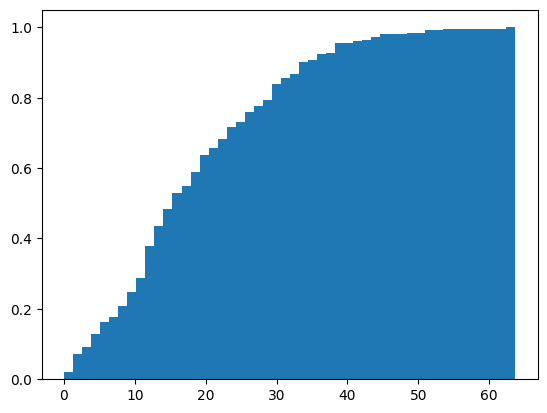

In [159]:
fig, ax = plt.subplots()
ax.hist(tstats, bins=50, cumulative=True, density=True)

In [118]:
size = np.array(size)

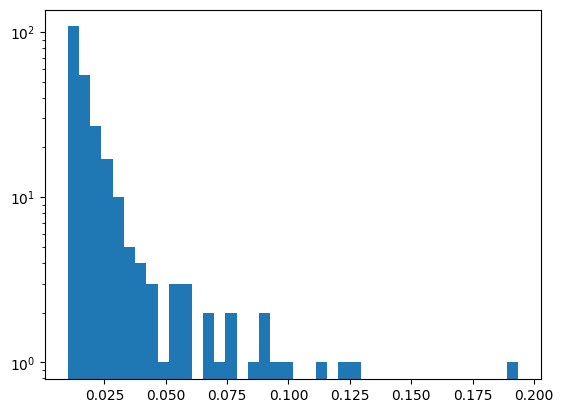

In [121]:
plt.hist(size, bins=40)
plt.yscale("log")

In [125]:
outcome = np.array(outcome)
outcome_prune = np.array(outcome_prune)
ranks = np.array(ranks)
sigma_dists = np.array(sigma_dists)

In [148]:
sup = 0.015

In [149]:
outcome[size < sup].shape

(110,)

In [150]:
outcome_prune[size < sup].mean()

0.1

In [151]:
outcome[size < sup].mean()

0.9363636363636364

In [ ]:
outcome[size < 0.02].mean()

In [143]:
sigma_dists[size < 0.02].mean()

1.6234694945430161

In [144]:
ranks[size < 0.02].mean()

0.2434550136492761

In [145]:
np.median(1/ranks[size < 0.02])

10.0

In [162]:
from scipy.stats import ttest_ind

In [170]:
a = np.random.normal(0, 1, 1_000)
b = np.random.normal(0.1, 1, 1_000)
print(1_000, "=>", abs(ttest_ind(a, b, equal_var=False).statistic))

a = np.random.normal(0, 1, 100_000)
b = np.random.normal(0.1, 1, 100_000)
print(100_000, "=>", abs(ttest_ind(a, b, equal_var=False).statistic))

1000 => 1.5459424698306727
100000 => 22.48469436048745


In [125]:
import pickle
import seaborn as sns

In [126]:
with open("output-experiments.pkl", "rb") as f:
    experiments = pickle.load(f)

with open("output-experiments-11-15.pkl", "rb") as f:
    experiments.update(pickle.load(f))

In [127]:
experiments.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [155]:
len(experiments[2][0])

10

(14, 10)

3

outcome
outcome_prune
sigma_dists
ranks
size
tstats
candidates_num
deltas
corr_overlap_delta
corr_overlap_tstat


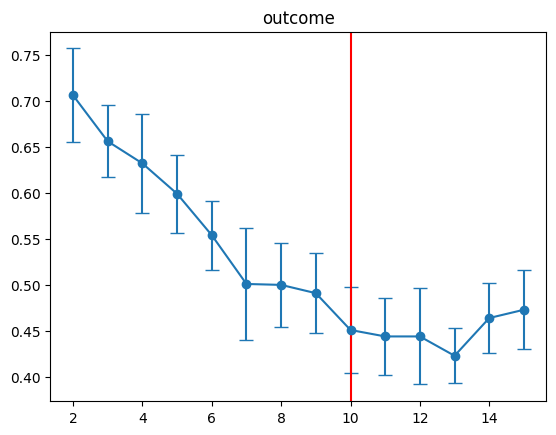

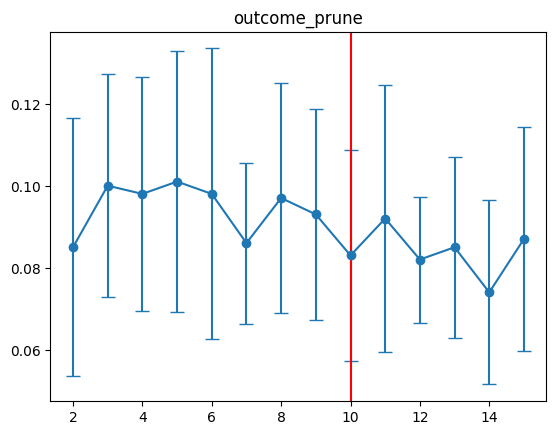

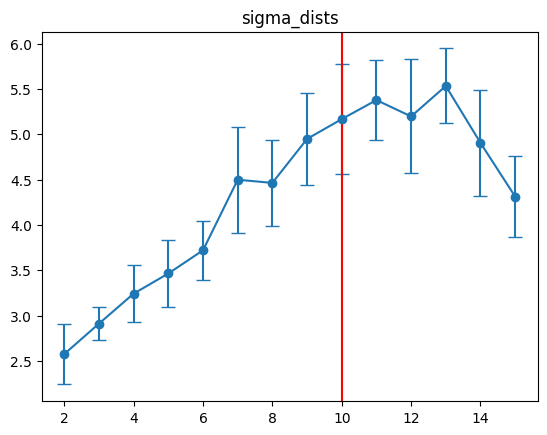

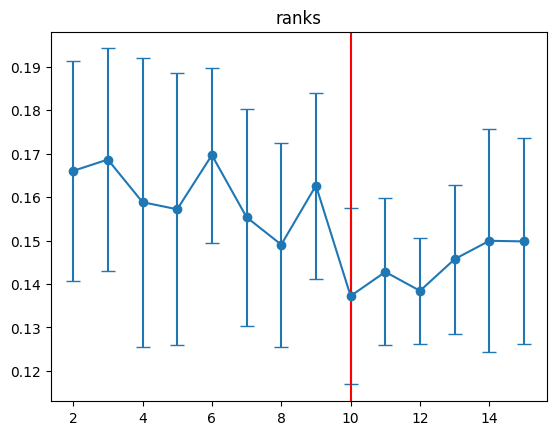

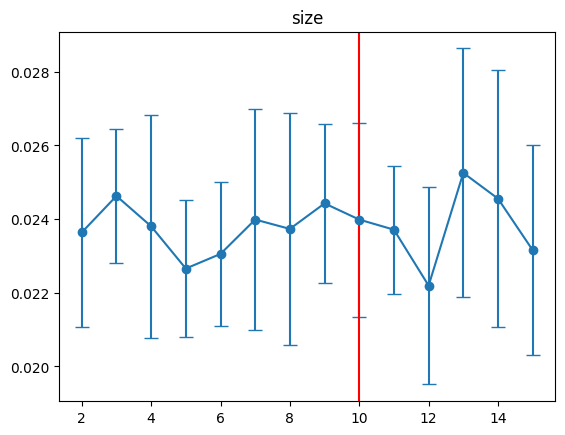

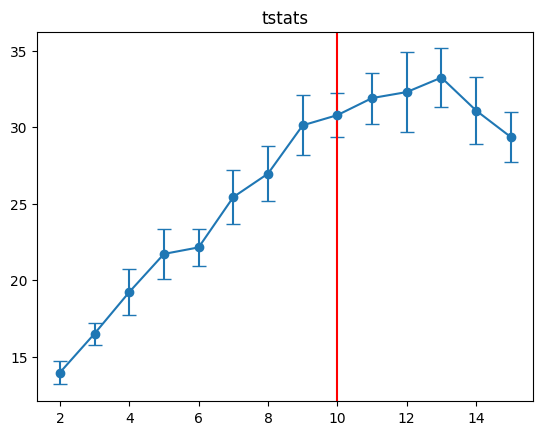

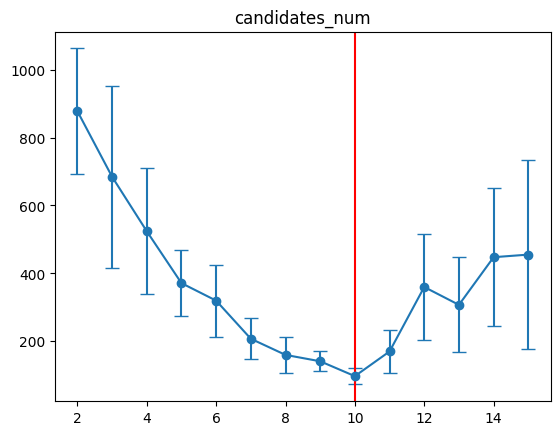

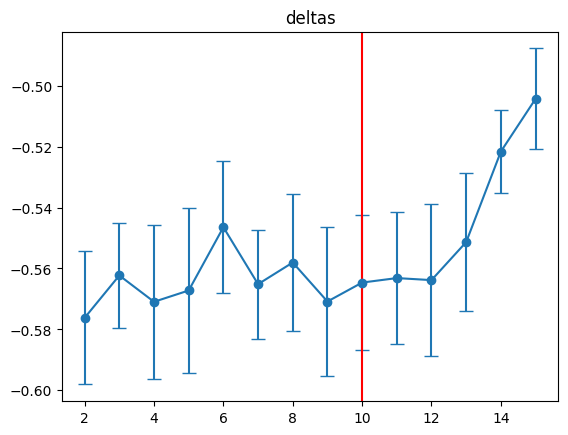

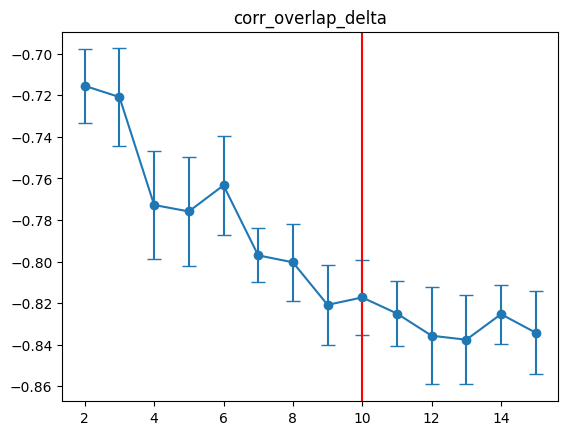

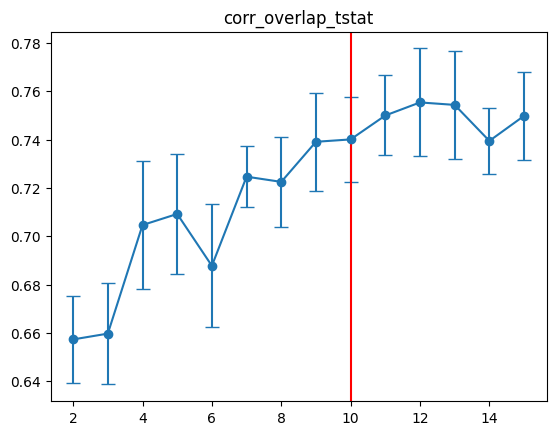

In [ ]:
# plt.plot([ np.mean([ experiments[w][i]["ranks"].mean() for i in range(len(experiments[w])) ]) for w in experiments.keys() ])

for k in experiments[2][0].keys():
    fig, ax = plt.subplots()
    print(k)
    # ax.plot([ np.mean([ experiments[w][i][k].mean() for i in range(len(experiments[w])) ]) for w in experiments.keys() ])

    X = np.array([ [ experiments[w][i][k].mean() for i in range(len(experiments[w])) ] for w in experiments.keys() ])

    # with whiskers
    ax.errorbar(range(2, 16), X.mean(axis=1), yerr=X.std(axis=1), fmt='o-', capsize=5)
    ax.axvline(10, c='r')
    ax.set_title(k)
    ax.set_xlabel("Window size")
    ax.set_ylabel(k)

In [65]:
from torchvision.transforms import GaussianBlur
import numpy as np

In [66]:
def closest_odd(n):
    return 2 * int(n / 2) + 1

start_noise = 0
n_batches = 20
blurs = [None] * start_noise + [
    GaussianBlur(closest_odd(i), sigma=i) if i > 0 else lambda x : x # identity if sigma=0
    for i in np.linspace(1, 25, n_batches - start_noise)
]


In [67]:
from torchvision.datasets import CelebA

ds = CelebA(root="data", split="train", target_type="attr", download=True)

Files already downloaded and verified


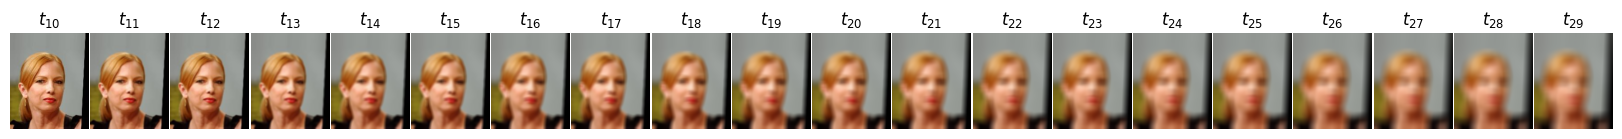

In [75]:
fig, ax = plt.subplots(1, n_batches, figsize=(20.7, 1.25))
for i in range(len(blurs)):
    ax[i].imshow(blurs[i](ds[8000][0]))
    ax[i].axis("off")
    ax[i].set_title(f"$t_{{{i+10}}}$")
# reduce white space between subplots
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig("noise.pdf", bbox_inches="tight")

In [64]:
divs

NameError: name 'divs' is not defined

In [4]:
# implement AND operation as product between boolean vectors 
mm_bool = matches.matches.astype(bool)
all_experiments = {}

for window in [2, 5, 10]:
# for window in range(2, 11):

    if window not in all_experiments:
        all_experiments[window] = []
    

    print("Window", window)

    start_noise = window

    sigmas = 3

    outcome = []
    outcome_prune = []
    sigma_dists = []
    ranks = [] # for mrr
    size = []
    tstats = []
    candidates_num = []
    deltas = []
    corr_overlap_delta = []
    corr_overlap_tstat = []

    np.random.shuffle(target_files)
    n_files = 100

    with tqdm(target_files[:n_files]) as pbar:
        for tgt_file in pbar:
            with open(tgt_file, "rb") as f:
                obj = pickle.load(f)
                sg = frozenset(obj["subgroup"])
                accuracies = obj["accuracies"]
                f1 = obj["f1"]
                divs = obj["divs"]
                y_trues = obj["y_trues"]
                y_preds = obj["y_preds"]
                blurs = obj["blurs"]

            for d in divs:
                d.set_index("subgroup", inplace=True)
                d["accuracy"] = (d["tp"] + d["tn"]) / (d["tp"] + d["tn"] + d["fp"] + d["fn"])

            ndx = divs[0].index
            ndx_target = (ndx == sg).nonzero()[0][0]
            size.append(matches.matches[:, [ndx_target]].mean())

            # "broadcast" to desired shape (matrix multiplication with vector of 1's)
            ndx_vec_bool = (matches.matches[:, [ndx_target]].astype(bool) @ csr_array(np.ones((1, matches.matches.shape[1]))).astype(bool))
            overlaps = (mm_bool * ndx_vec_bool).sum(axis=0) # element-wise product as "&", sum along axis=0 to get count of matches
            total = matches.matches.sum(axis=0)
            overlaps = overlaps / total

            a1 = reduce(lambda a,b : a + b, [ div["tp"] + div["tn"] for div in divs[:start_noise] ])
            b1 = reduce(lambda a,b : a + b, [ div["fp"] + div["fn"] for div in divs[:start_noise] ])

            E1 = a1 / (a1 + b1)
            Var1 = (a1 * b1) / ((a1 + b1) ** 2 * (a1 + b1 + 1))

            a2 = reduce(lambda a,b : a + b, [ div["tp"] + div["tn"] for div in divs[-window:] ])
            b2 = reduce(lambda a,b : a + b, [ div["fp"] + div["fn"] for div in divs[-window:] ])

            E2 = a2 / (a2 + b2)
            Var2 = (a2 * b2) / ((a2 + b2) ** 2 * (a2 + b2 + 1))

            delta = E2 - E1
            variance = Var1 + Var2
            t_stat = abs(delta) / np.sqrt(variance + 1e-12) # eps to avoid division by 0

            # compute as average accuracy across batches
            # E1 = reduce(lambda a,b : a + b, [ div["accuracy"] for div in divs[:start_noise] ]) / start_noise
            # E2 = reduce(lambda a,b : a + b, [ div["accuracy"] for div in divs[-window:] ]) / window

            # delta = E2 - E1
            # Var1 = reduce(lambda a,b : a + b, [ (div["accuracy"] - E1) ** 2 for div in divs[:start_noise] ]) / (start_noise - 1)
            # Var2 = reduce(lambda a,b : a + b, [ (div["accuracy"] - E2) ** 2 for div in divs[-window:] ]) / (window - 1)

            # t_stat = abs(delta) / np.sqrt(Var1 / start_noise + Var2 / window)


            # mask_3sigma = (delta < (delta.min() + sigmas * variance[delta.argmin()]**.5))
            # candidates = set(divs[0].loc[mask_3sigma].index)

            topn = 200
            candidates = set(delta.sort_values()[:topn].index)


            kept = []

            # if sg not in candidates:
            #     print("Not in candidates", tgt_file)
            #     break
            candidates_num.append(len(candidates))
            tstats.append(t_stat[sg])
            deltas.append(delta[sg])

            outcome.append(sg in candidates)
            sigma_dists.append((delta[sg] - delta[delta.argmin()]) / (variance[delta.argmin()]) ** 0.5)
            ranks.append(1/delta.rank(method="dense")[sg])

            corr_overlap_delta.append(np.corrcoef(overlaps, delta)[0,1])
            corr_overlap_tstat.append(np.corrcoef(overlaps, t_stat)[0,1])

            for el in candidates:
                shortest = True
                for oth in candidates:
                    if oth == el:
                        continue
                    
                    if oth < el:
                        shortest = False
                        break
                if shortest:
                    kept.append(el)
            
            outcome_prune.append(sg in kept)

            pbar.set_postfix({"outcome": np.mean(outcome), "outcome_prune": np.mean(outcome_prune), "sigma_dist": np.mean(sigma_dists), "mrr": np.mean(ranks), "tstat": np.mean(tstats), "deltas": np.mean(deltas), "corr_overlap_delta": np.mean(corr_overlap_delta), "corr_overlap_tstat": np.mean(corr_overlap_tstat)})
            
    
    outcome = np.array(outcome)
    outcome_prune = np.array(outcome_prune)
    sigma_dists = np.array(sigma_dists)
    ranks = np.array(ranks)
    size = np.array(size)
    tstats = np.array(tstats)
    candidates_num = np.array(candidates_num)
    deltas = np.array(deltas)
    corr_overlap_delta = np.array(corr_overlap_delta)
    corr_overlap_tstat = np.array(corr_overlap_tstat)

    all_experiments[window].append({
        "outcome": outcome,
        "outcome_prune": outcome_prune,
        "sigma_dists": sigma_dists,
        "ranks": ranks,
        "size": size,
        "tstats": tstats,
        "candidates_num": candidates_num,
        "deltas": deltas,
        "corr_overlap_delta": corr_overlap_delta,
        "corr_overlap_tstat": corr_overlap_tstat
    })


Window 2


100%|██████████| 100/100 [02:23<00:00,  1.43s/it, outcome=0.75, outcome_prune=0.05, sigma_dist=2.64, mrr=0.139, tstat=13.5, deltas=-.576, corr_overlap_delta=-.74, corr_overlap_tstat=0.679]   


Window 5


100%|██████████| 100/100 [02:33<00:00,  1.53s/it, outcome=0.76, outcome_prune=0.05, sigma_dist=3.53, mrr=0.154, tstat=22.8, deltas=-.582, corr_overlap_delta=-.803, corr_overlap_tstat=0.733]  


Window 10


100%|██████████| 100/100 [02:29<00:00,  1.50s/it, outcome=0.72, outcome_prune=0.06, sigma_dist=6.05, mrr=0.108, tstat=30.6, deltas=-.564, corr_overlap_delta=-.819, corr_overlap_tstat=0.737]  


In [5]:
cnt = 0
skip = 5
for window in range(2, 11):
    start_w = skip
    end_w = window+skip

    for start_w2 in range(end_w, 30 - window):
        end_w2 = start_w2 + window
        cnt += 1
        # print(start_w, end_w, start_w2, end_w2)
        if (start_w, end_w, start_w2, end_w2) == (5, 14, 20, 29):
            print(cnt)
print(cnt)

112
117


In [70]:
for div in divs:
    div["accuracy"] = (div["tp"] + div["tn"]) / (div["tp"] + div["tn"] + div["fp"] + div["fn"])

In [79]:
from functools import reduce

reduce(lambda a,b: a+b, [ div["accuracy"] for div in divs[:10] ]) / 10

subgroup
(23)               0.777845
(19)               0.785655
(2)                0.775466
(16)               0.965632
(38)               0.758428
                     ...   
(5, 21, 6)         0.915582
(5, 19, 21, 6)     0.915582
(19, 20, 21)       0.890952
(20, 21, 6)        0.910612
(19, 20, 21, 6)    0.910612
Name: accuracy, Length: 26597, dtype: float64

In [74]:
start_noise

0

In [3]:
import pickle
import numpy as np

with open("output-experiments-skip-0-topn-200-run2.pkl", "rb") as f:
    results = pickle.load(f)

In [4]:
max_win_size = None
max_delay = None

topn = 200

for start_ref_win, end_ref_win, start_curr_win, end_curr_win in results:
    assert end_ref_win - start_ref_win == end_curr_win - start_curr_win

    window = end_ref_win - start_ref_win
    delay = start_curr_win - end_ref_win

    if max_win_size is None or max_delay is None:
        max_win_size = window
        max_delay = delay
    
    max_win_size = max(max_win_size, window)
    max_delay = max(max_delay, delay)

key = list(results.keys())[0]
sg_pos = np.array([ (matches.fi.itemsets == i).values.nonzero()[0][0] for i in results[key][0]["sgs"] ])

# mat_tstat = np.full((max_win_size+1, max_delay+1), np.nan)
# mat_delta = np.full((max_win_size+1, max_delay+1), np.nan)
mat_tstat = np.full((max_win_size+1, 30), np.nan)
mat_delta = np.full((max_win_size+1, 30), np.nan)

for key in results:
    start_ref_win, end_ref_win, start_curr_win, end_curr_win = key
    window = end_ref_win - start_ref_win
    delay = start_curr_win - end_ref_win

    crop_topn_tstat = results[key][0]["tstats"].argsort(axis=1)[:, -topn:]
    crop_topn_delta = results[key][0]["deltas"].argsort(axis=1)[:, :topn]
    found = (crop_topn_tstat == sg_pos.reshape(-1,1)).any(axis=1)
    mat_tstat[window, delay+window*2-1] = found.mean()

    found = (crop_topn_delta == sg_pos.reshape(-1,1)).any(axis=1)
    mat_delta[window, delay+window*2-1] = found.mean()

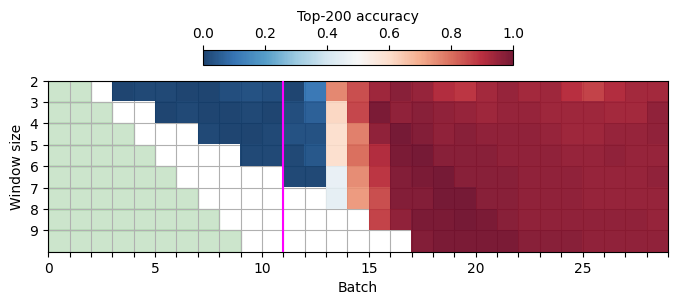

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
# include legend for colors
m = ax.imshow(mat_tstat, vmin=0, vmax=1, zorder=2, extent=[0, 30, max_win_size+1, 0], cmap='RdBu_r', alpha=.9)
ax.set_xticks(range(30))
ax.set_yticks(range(max_win_size+1))
# shift all ticks 0.5 right
ax.set_xticklabels([ str(i) if i % 5 == 0 else "" for i in range(30) ])



for ws in range(2, max_win_size+1):
    # draw rectangle of size win_size on the left
    # black borders
    ax.add_patch(plt.Rectangle((0, ws), ws, 1, color='g', alpha=.2, zorder=1))


ax.set_xlabel("Batch")
ax.set_ylabel("Window size")
ax.grid()
ax.axvline(11, c='#f0f', zorder=3)
ax.set_xlim([0, 30-1])
ax.set_ylim([max_win_size+1, 2])
fig.colorbar(m, shrink=0.5, orientation="horizontal",  ax=ax, label=f"Top-{topn} accuracy", location="top")
fig.savefig("ttest-corr.pdf", bbox_inches="tight")

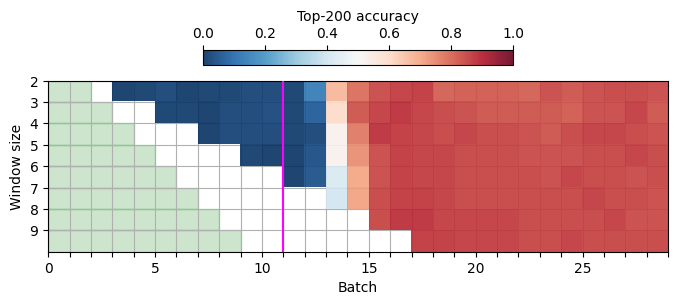

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
# include legend for colors
m = ax.imshow(mat_delta, vmin=0, vmax=1, zorder=2, extent=[0, 30, max_win_size+1, 0], cmap='RdBu_r', alpha=.9)
ax.set_xticks(range(30))
ax.set_yticks(range(max_win_size+1))
# shift all ticks 0.5 right
ax.set_xticklabels([ str(i) if i % 5 == 0 else "" for i in range(30) ])



for ws in range(2, max_win_size+1):
    # draw rectangle of size win_size on the left
    # black borders
    ax.add_patch(plt.Rectangle((0, ws), ws, 1, color='g', alpha=.2, zorder=1))


ax.set_xlabel("Batch")
ax.set_ylabel("Window size")
ax.grid()
ax.axvline(11, c='#f0f', zorder=3)
ax.set_xlim([0, 30-1])
ax.set_ylim([max_win_size+1, 2])
fig.colorbar(m, shrink=0.5, orientation="horizontal",  ax=ax, label=f"Top-{topn} accuracy", location="top")
fig.savefig("delta-corr.pdf", bbox_inches="tight")

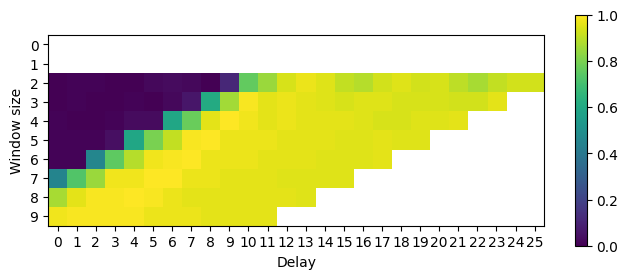

In [11]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 4))
# include legend for colors
m = ax.imshow(mat, cmap='viridis', vmin=0, vmax=1)
ax.set_xticks(range(max_delay+1))
ax.set_yticks(range(max_win_size+1))
ax.set_xlabel("Delay")
ax.set_ylabel("Window size")
# make the colorbar shorter
fig.colorbar(m, shrink=0.75)
# fig.colorbar(m) # 200


In [12]:
mat

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [0.  , 0.01, 0.01, 0.  , 0.  , 0.02, 0.03, 0.02, 0.  , 0.11, 0.76,
        0.85, 0.94, 0.97, 0.95, 0.91, 0.89, 0.93, 0.95, 0.93, 0.94, 0.9 ,
        0.87, 0.91, 0.93, 0.93],
       [0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.02, 0.06, 0.61, 0.86, 0.99,
        0.96, 0.97, 0.96, 0.95, 0.94, 0.95, 0.95, 0.94, 0.94, 0.94, 0.93,
        0.93, 0.96,  nan,  nan],
       [0.01, 0.  , 0.  , 0.01, 0.03, 0.03, 0.59, 0.77, 0.96, 1.  , 0.98,
        0.96, 0.97, 0.96, 0.96, 0.96, 0.95, 0.94, 0.94, 0.95, 0.95, 0.96,
         nan,  nan,  nan,  nan],
       [0.01, 0.01, 0.01, 0.04, 0.59, 0.8 , 0.91, 0.99, 1.  , 0.97, 0.97,
        0.97, 0.96, 0

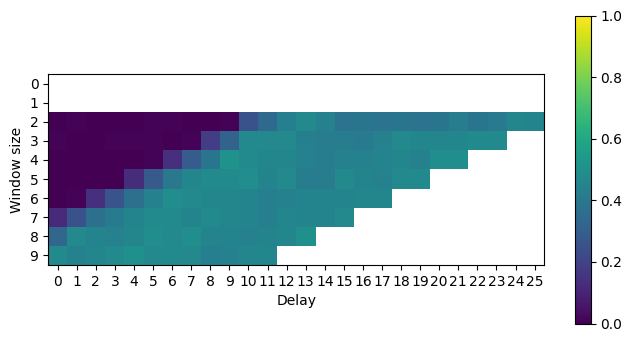

In [204]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 4))
# include legend for colors
m = ax.imshow(mat, cmap='viridis', vmin=0, vmax=1)
ax.set_xticks(range(max_delay+1))
ax.set_yticks(range(max_win_size+1))
ax.set_xlabel("Delay")
ax.set_ylabel("Window size")
fig.colorbar(m) # 25


In [94]:
max_win_size = None
max_delay = None

topn = 200

for start_ref_win, end_ref_win, start_curr_win, end_curr_win in results:
    assert end_ref_win - start_ref_win == end_curr_win - start_curr_win

    window = end_ref_win - start_ref_win
    delay = start_curr_win - end_ref_win

    if max_win_size is None or max_delay is None:
        max_win_size = window
        max_delay = delay
    
    max_win_size = max(max_win_size, window)
    max_delay = max(max_delay, delay)

mat = np.full((max_win_size+1, max_delay+1), np.nan)
for key in results:
    start_ref_win, end_ref_win, start_curr_win, end_curr_win = key
    window = end_ref_win - start_ref_win
    delay = start_curr_win - end_ref_win

    mat[window, delay] = results[key][0]["ranks"].mean()

In [100]:
matches.matches.shape

(101300, 26597)